In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt
from fuzzy_layer import FuzzyLayer
import matplotlib.pyplot as plt


np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
timeseries_length = 80

Сгенерируем набор синусоид с двумя различными параметрами - фазой и частотой, и разметим классы:

0. Синус с периодом 2 pi
1. Косинус с периодом 2 pi
2. Синус с периодом 4 pi
3. Косинус с периодом 4 pi
4. Нет разметки

In [2]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, samples_count, timeseries_length):
        'Initialization'
        self.samples = samples_count
        self.timeseries_length = timeseries_length
    
    def __len__(self):
        'Denotes the total number of samples'
        return self.samples
    
    def __getitem__(self, index):
        'Generates one sample of data'
        
        phase_state = np.random.randint(0,11)
        freq_state = np.random.randint(0,11)

        freq = (freq_state + 10) / 10.0
        phase = phase_state / 10.0
        
        t = np.linspace(0.0, 6.0 * np.pi, self.timeseries_length)
        X =(1.0 + np.sin(phase * np.pi/2.0 - freq * t)) / 2.0

        X = torch.from_numpy(X.reshape((1,self.timeseries_length))).type('torch.FloatTensor')
        
        y = 4
        if phase_state == 0 and freq_state == 0:
            y = 0
        elif phase_state == 10 and freq_state == 0:
            y = 1
        elif phase_state == 0 and freq_state == 10:
            y = 2
        elif phase_state == 10 and freq_state == 10:
            y = 3

        return X, y
    
training_set = Dataset(1000, timeseries_length)
train_gen = torch.utils.data.DataLoader(training_set, batch_size=128, shuffle = True, num_workers = 0, drop_last=True)

testing_set = Dataset(128, timeseries_length)
test_gen = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle = True, num_workers = 0, drop_last=True)

Определим структуру VAE для одномерного сигнала

In [3]:
class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()
        
        self.latent_dimension = 10

        self.convolutions = nn.Sequential(
            nn.Conv1d(1, 32, 20),
            nn.BatchNorm1d(32),
            nn.Conv1d(32, 64, 20),
            nn.BatchNorm1d(64),
            nn.Flatten(),
            nn.Linear(2688, 1152),
            nn.BatchNorm1d(1152),
            nn.Sigmoid()
        )

        self.mu = nn.Sequential(
            nn.Linear(1152, self.latent_dimension),
            nn.BatchNorm1d(self.latent_dimension),
            nn.Sigmoid()
        )

        self.logvar = nn.Sequential(
            nn.Linear(1152, self.latent_dimension),
            nn.BatchNorm1d(self.latent_dimension),
            nn.Sigmoid()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dimension, 1152),
            nn.BatchNorm1d(1152),
            nn.Sigmoid(),
            nn.Linear(1152, 2688),
            nn.BatchNorm1d(2688),
            nn.Sigmoid(),
            nn.Unflatten(1, [64, 42]),
            nn.ConvTranspose1d(64, 32, 20),
            nn.BatchNorm1d(32),
            nn.ConvTranspose1d(32, 1, 20)
        )


    def encode(self, x):
        conv = self.convolutions.forward(x)
        mu = self.mu.forward(conv)
        logvar = self.logvar.forward(conv)
        return (mu, logvar)
    
    def decode(self, z_mean):
        return self.decoder.forward(z_mean);
        
    def forward(self, x):
        mu,_ = self.encode(x)
        return self.decoder(mu)
        
model = VAE().to(device)
input = torch.randn(10, 1, timeseries_length).to(device)


output = model(input)

output.shape

torch.Size([10, 1, 80])

Обучим модельку

In [4]:
lrate = 0.001
optimizer = torch.optim.Adam(
            model.parameters(),
            lr = lrate)

def VAE_loss(x_tilde, x, mu, logvar, beta):
    mse = nn.functional.mse_loss(x_tilde, x, reduction = 'sum')
    KL = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    return mse + beta * KL 

In [5]:
def train_model(beta, epochs, model):
    dic = dict(latent_space = list(), mu_list=list(), logsig2_list=list(), y=list())
    for epoch in range(0, epochs + 1):
        # ========= training =========
        if epoch > 0: 
            model.train()
            train_loss = 0
            for X, _ in train_gen:
                X = X.to(device)
                # forward pass ...
                mu, logvar = model.encode(X)

                epsilon = torch.randn_like(mu).to(device)
                z = mu + torch.exp(0.5 * logvar) * epsilon      
                x_tilde = model.decode(z)


                loss = VAE_loss(x_tilde, X, mu, logvar, beta)
                train_loss += loss.item()
                # backward pass ...
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # log ...
            print(f'----> Epoch: {epoch} Average loss: {train_loss / len(train_gen.dataset):.4f}')

        # ========= validation ========= 
        z_list, means, logvars , labels = list(), list(), list(), list()
        with torch.no_grad():
            model.eval()
            test_loss = 0
            for X, Y in test_gen:
                X = X.to(device)
                # forward ...
                mu, logvar = model.encode(X)
                x_tilde = model.decode(mu)
                
                test_loss += VAE_loss(x_tilde, X, mu, logvar, beta).item()
                # log ...
                z_list.append(mu.detach())
                means.append(mu.detach())
                logvars.append(logvar.detach())
                labels.append(Y.detach())
        # log ...
        dic['latent_space'].append(torch.cat(z_list))
        dic['mu_list'].append(torch.cat(means))
        dic['logsig2_list'].append(torch.cat(logvars))
        dic['y'].append(torch.cat(labels))
        test_loss /= len(test_gen.dataset)
        print(f'----> Test set loss: {test_loss:.4f}')
    return dic
    
beta = 1
epochs = 50
dic = train_model(beta, epochs, model)

----> Test set loss: 91.0446
----> Epoch: 1 Average loss: 811.0609
----> Test set loss: 597.2666
----> Epoch: 2 Average loss: 126.1309
----> Test set loss: 109.8715
----> Epoch: 3 Average loss: 83.4664
----> Test set loss: 56.2706
----> Epoch: 4 Average loss: 52.9361
----> Test set loss: 92.7655
----> Epoch: 5 Average loss: 41.5643
----> Test set loss: 66.6642
----> Epoch: 6 Average loss: 32.9434
----> Test set loss: 26.8880
----> Epoch: 7 Average loss: 27.8994
----> Test set loss: 24.5986
----> Epoch: 8 Average loss: 23.6105
----> Test set loss: 27.5947
----> Epoch: 9 Average loss: 21.1139
----> Test set loss: 21.0158
----> Epoch: 10 Average loss: 18.7722
----> Test set loss: 19.1651
----> Epoch: 11 Average loss: 17.1236
----> Test set loss: 18.2942
----> Epoch: 12 Average loss: 16.0476
----> Test set loss: 16.2112
----> Epoch: 13 Average loss: 15.1129
----> Test set loss: 15.2528
----> Epoch: 14 Average loss: 14.3326
----> Test set loss: 14.7235
----> Epoch: 15 Average loss: 13.6220


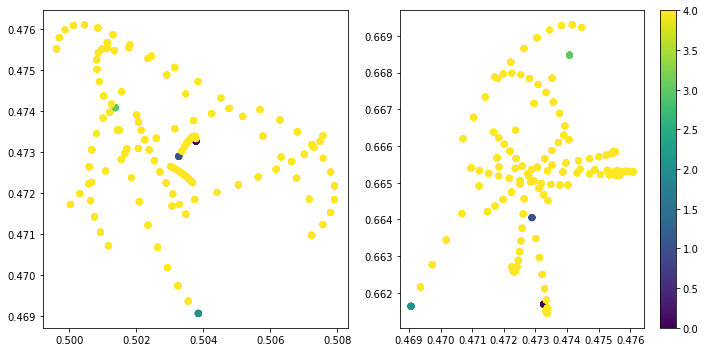

In [6]:
z_arr = dic['latent_space'][0].cpu().numpy()
y_arr = dic['y'][0].cpu().numpy()
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.scatter(z_arr[:,0], z_arr[:,1], c = y_arr)
plt.subplot(1,2,2)
plt.scatter(z_arr[:,1], z_arr[:,2], c = y_arr)
plt.colorbar()
plt.tight_layout()



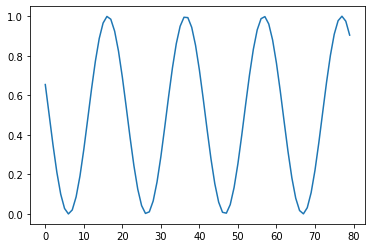

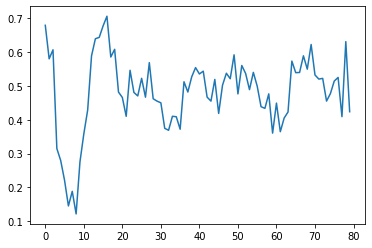

In [23]:
model.eval()
for X, y in test_gen:
    plt.plot(X[0,0])
    plt.show()
    mu, logvar = model.encode(X)
    x_tilde = model.decode(mu)
    plt.plot(x_tilde.detach().numpy()[0,0])
    plt.show()
    break

In [8]:
a = torch.randn(10, 1, timeseries_length, device=device)
b = torch.randn(10, 1, timeseries_length, device=device)

recon_loss = torch.square(a - b)
srecon_loss = recon_loss.sum(-1).sum(-1)
srecon_loss.sum()

tensor(1654.9243)